In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import os.path as osp
import pandas as pd

In [47]:
history_path = "mobilenet_ckpts/history/"
history = []
for f in os.walk(history_path):
    for file in f[2]:
        data = torch.load(osp.join("mobilenet_ckpts/history/", file))
        h = dict(epoch=data["epoch"], train_loss=data["loss"]["loss"], val_loss=data["eval_loss"]["loss"]
                )
        for k, v in data["loss"].items():
            h[f"train_{k}"] = v
        for k, v in data["eval_loss"].items():
            h[f"val_{k}"] = v
        history.append(
            h
        )

In [48]:
df = pd.DataFrame(history)
df = df.sort_values("epoch").set_index("epoch")
df.head()

,train_loss,val_loss,train_top_1_acc,train_top_5_acc,train_top_10_acc,val_top_1_acc,val_top_5_acc,val_top_10_acc
epoch,,,,,,,,
0,5.026392,4.671656,0.026058,0.096448,0.165392,0.049125,0.174202,0.275560
1,4.534294,4.339657,0.064495,0.207774,0.318307,0.079294,0.248992,0.374535
2,4.223221,4.056573,0.099767,0.282247,0.408278,0.115919,0.320739,0.453014
3,3.953065,3.802498,0.134297,0.351058,0.483876,0.156073,0.388270,0.524618
4,3.729498,3.669123,0.166234,0.403707,0.538115,0.172473,0.416539,0.554017


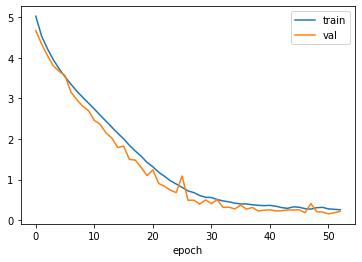

In [49]:
df['train_loss'].plot(label="train")
df['val_loss'].plot(label="val")
plt.legend()